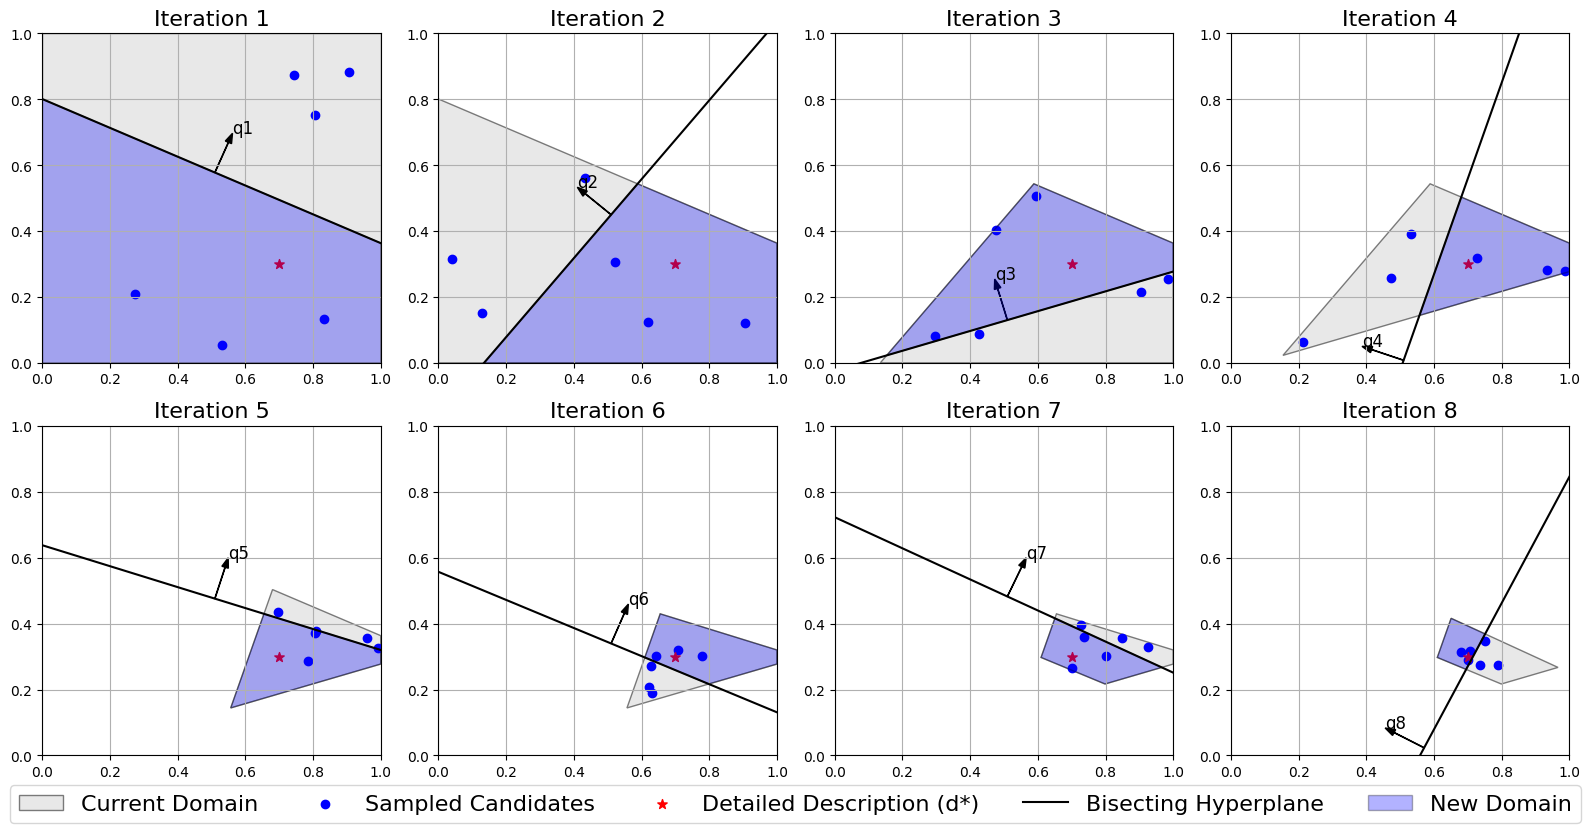

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
import shapely.geometry
import shapely.ops
import random 

def sample_points_within_polygon(polygon, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

def create_half_plane_polygon(p0, n, d, L, M, inequality):
    # create a polygon representing the half-plane defined by the line and the inequality.
    d_perp = np.array([-n[1], n[0]])
    p1 = p0 + L * d_perp
    p2 = p0 - L * d_perp
    if inequality == "<=":
        p1_shift = p1 - M * n
        p2_shift = p2 - M * n
    else:
        p1_shift = p1 + M * n
        p2_shift = p2 + M * n
    coords = [tuple(p1), tuple(p2), tuple(p2_shift), tuple(p1_shift)]
    half_plane_polygon = Polygon(coords)
    return half_plane_polygon

# initial domain
domain = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
num_iterations = 8

# define the optimum point s^*
s_star = Point(0.7, 0.3) # example
# subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for iteration in range(num_iterations):
    # sample 6 random points
    points = sample_points_within_polygon(domain, 6)
    coords = np.array([point.coords[0] for point in points])
    # randomly select a direction
    theta = np.random.uniform(0, np.pi)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    # project points onto theta
    projections = coords[:, 0] * cos_theta + coords[:, 1] * sin_theta
    # compute the median of projections
    median_proj = np.median(projections)
    # compute the projection of s_star
    proj_s_star = s_star.x * cos_theta + s_star.y * sin_theta
    # define the inequality based on the position of s_star
    if proj_s_star >= median_proj:
        inequality = ">="
    else:
        inequality = "<="
    # line equation: x * cos_theta + y * sin_theta = median_proj
    # normal vector
    n = np.array([cos_theta, sin_theta])
    # find a point on the line
    epsilon = 1e-6
    if abs(sin_theta) > epsilon:
        x0 = 0
        y0 = median_proj / sin_theta
    elif abs(cos_theta) > epsilon:
        x0 = median_proj / cos_theta
        y0 = 0
    else:
        # when both sin_theta and cos_theta are close to zero
        x0, y0 = 0, 0
    p0 = np.array([x0, y0])
    # create half-plane
    L = 100
    M = 100
    half_plane_polygon = create_half_plane_polygon(p0, n, theta, L, M, inequality)
    # update the domain
    new_domain = domain.intersection(half_plane_polygon)
    # determine subplot indices
    row = iteration // 4
    col = iteration % 4
    ax = axs[row][col]
    # plotting on the current subplot
    x_domain, y_domain = domain.exterior.xy
    ax.fill(x_domain, y_domain, alpha=0.5, fc='lightgray', ec='black', label='Current Domain')
    # plot the sampled points
    ax.scatter(coords[:, 0], coords[:, 1], color='blue', label='Sampled Candidates')
    # plot s_star
    ax.scatter(s_star.x, s_star.y, color='red', s=50,marker='*', label='Detailed Description (d*)')

    # plot the dividing line, generate points along the line
    line_x = np.linspace(-0.5, 1.5, 100)
    # handle division by zero
    if abs(sin_theta) > epsilon:
        line_y = (median_proj - line_x * cos_theta) / sin_theta
    else:
        line_y = np.full_like(line_x, y0)
    ax.plot(line_x, line_y, color='black', label='Bisecting Hyperplane')

    # plot the normal vector 'q'
    idx = len(line_x) // 2 
    start_x = line_x[idx]
    start_y = line_y[idx]
    # limits
    if 0 <= start_x <= 1 and 0 <= start_y <= 1:
        arrow_length = 0.1 
        dx = arrow_length * n[0]
        dy = arrow_length * n[1]
        ax.arrow(start_x, start_y, dx, dy, head_width=0.02, head_length=0.03, fc='black', ec='black')
        ax.text(start_x + dx*1.3, start_y + dy*1.3, f'q{iteration + 1}', color='black', fontsize=12)
    else:
        # try another one
        for i in range(len(line_x)):
            start_x = line_x[i]
            start_y = line_y[i]
            if 0 <= start_x <= 1 and 0 <= start_y <= 1:
                # scale the normal vector
                arrow_length = 0.1
                dx = arrow_length * n[0]
                dy = arrow_length * n[1]
                ax.arrow(start_x, start_y, dx, dy, head_width=0.02, head_length=0.03, fc='black', ec='black')
                ax.text(start_x + dx*1.3, start_y + dy*1.3, f'q{iteration+ 1}', color='black', fontsize=12)
                break  # stop when found

    # plot new domain
    if not new_domain.is_empty:
        if isinstance(new_domain, Polygon):
            x_new_domain, y_new_domain = new_domain.exterior.xy
            ax.fill(x_new_domain, y_new_domain, alpha=0.3, fc='blue', ec='black', label='New Domain')
        else:
            # if new_domain is a MultiPolygon (never happens)
            for geom in new_domain.geoms:
                if isinstance(geom, Polygon):
                    x_new_domain, y_new_domain = geom.exterior.xy
                    ax.fill(x_new_domain, y_new_domain, alpha=0.3, fc='blue', ec='black', label='New Domain')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Iteration {iteration + 1}', fontsize=16)
    ax.grid(True)

    # update the domain
    domain = new_domain
# plot
plt.tight_layout()
handles, labels = [], []
for ax in axs.flatten():
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        if label not in labels and label != '_nolegend_':
            handles.append(handle)
            labels.append(label)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), fontsize=16, ncol=5)
plt.show()